In [18]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

# Задание 1

In [19]:
class DecisionTree():
    class Node():
        def __init__(self):
            self.rule = -1
            self.threshold = None
            self.left_node = None
            self.right_node = None
            self.node_class = None
            
    def __init__(self, debug=''):
        self.tree = None
        self.debug = debug
        self.impurity_f = {
            'entropy': self.get_entropy,
            'gini': self.get_gini
        }
    
    def get_entropy(self, cnt, n): 
        entropy = 0
        for _, class_n in cnt.most_common():
            if class_n > 0:
                entropy -= (class_n/n * np.log2(class_n/n))
        return entropy
    
    def get_gini(self, cnt, n):
        gini = 0
        for _, class_n in cnt.most_common():
            gini += class_n/n * (1 - class_n/n)
        return gini
        
    def get_IG_threshold(self, v, y, n, impurity_f):
        sorted_vy = sorted(list(zip(v, y)))
        best_threshold = None
        best_IG = None
        y_left_cnt = Counter()
        y_right_cnt = Counter([t[1] for t in sorted_vy[0:]])
        n_left = 0
        n_right = len(sorted_vy)
        total_IG = n_right/n * impurity_f(y_right_cnt, n_right) # all values    
        for pos, (v, y) in enumerate(sorted_vy):
            if pos > 0 and (sorted_vy[pos][0] != sorted_vy[pos-1][0]):
                left_IG = n_left/n * impurity_f(y_left_cnt, n_left)
                right_IG = n_right/n * impurity_f(y_right_cnt, n_right)
                IG = total_IG - left_IG - right_IG
                if best_IG is None or IG > best_IG:
                    best_IG = IG
                    best_threshold = v
            y_left_cnt[y] = y_left_cnt[y] + 1
            n_left += 1
            y_right_cnt[y] -= 1
            n_right -= 1
        return best_IG, best_threshold
    def build_tree(self, node, X, y, n, level, max_level, impurity):
        cnt_y = Counter(y)
        if len(cnt_y) == 1:
            node.node_class = y[0]
            return
        if level == max_level:
            node.node_class = cnt_y.most_common()[0][0]
            return
        features_num = X.shape[1]
        features2IG = []
        for feature in range(0, features_num):
            IG, threshold = self.get_IG_threshold(X[:, feature], y, n, self.impurity_f[impurity])
            if IG is not None:
                features2IG.append((IG, threshold, feature))
        if len(features2IG) == 0:
            node.node_class = y[0]
            return
        IG, threshold, best_feature = sorted(features2IG, reverse=True)[0] # get always max
        node.IG = IG
        node.rule = best_feature
        node.threshold = threshold
        if 'v' in self.debug:
            print(f"[L{level}] n: {X.shape[0]}, feature: {node.rule}, threshold: {node.threshold}, IG: {IG}")
        
        # Left subtree
        node.left_node = self.Node()
        if 'vvv' in self.debug:
            print(f"[L{level}] Samples to left: {X[X[:, best_feature] < threshold].shape[0]}")
        self.build_tree(node.left_node,
                        X[X[:, best_feature] < threshold],
                        y[X[:, best_feature] < threshold],
                        n, level+1, max_level, impurity)
        # Right subtree
        node.right_node = self.Node()
        if 'vvv' in self.debug:
            print(f"[L{level}] Samples to right: {X[X[:, best_feature] >= threshold].shape[0]}")
        self.build_tree(node.right_node,
                        X[X[:, best_feature] >= threshold],
                        y[X[:, best_feature] >= threshold],
                        n, level+1, max_level, impurity) 
        return
        
    
    def fit(self, X, y, max_level=10, impurity='entropy'):
        self.tree = self.Node()
        self.build_tree(self.tree, X, y, X.shape[0], 0, max_level, impurity)
        
    def predict(self, X):
        predictions = []
        for sample in X:
            current_node = self.tree
            while current_node.node_class is None:
                if sample[current_node.rule] < current_node.threshold:
                    current_node = current_node.left_node
                else:
                    current_node = current_node.right_node
            predictions.append(current_node.node_class)
        return predictions

In [20]:
class RandomForest():
    def __init__(self):
        self.trees = []
        self.features_idx = []
        
    def fit(self, X, y, ntree=10, max_depth=None):
        n_samples = X.shape[0]
        m_features = X.shape[1]
        sampsize = int(np.round(0.632 * n_samples))
        mtry = int(np.round(np.sqrt(m_features)))
        for _ in range(ntree):
            tree = DecisionTree(debug='')
            row_idx = np.random.randint(0, n_samples, sampsize)
            col_idx = np.random.randint(0, m_features, mtry)
            tree.fit(X[row_idx[:, None], col_idx], y[row_idx], max_level=max_depth, impurity='gini')
            self.trees.append(tree)
            self.features_idx.append(col_idx)
    
    def predict(self, X, n_classes=2, voting='soft'):
        ntree = len(self.trees)
        n_samples = X.shape[0]
        predictions = np.zeros([ntree, n_samples, n_classes]) # 3d-array of shape <ntree, test_size, n_classes>
        for i in range(0, ntree):
            P = np.zeros([n_samples, n_classes])
            P[np.arange(n_samples), self.trees[i].predict(X[:, self.features_idx[i]])] = 1
            predictions[i, :, :] = P
        mean_predictions = np.mean(predictions, axis=0)
        classes = np.argmax(mean_predictions, axis=1)
        return mean_predictions, classes

# Задание 3

In [21]:
def ROC_AUC(y, probabilities):
    shifts = sorted(list(zip(probabilities, y)), reverse=True)
    step_x = 1/np.where(y != 1)[0].shape[0]
    step_y = 1/np.where(y == 1)[0].shape[0]
    points_x = [0]
    points_y = [0]
    last_x = 0
    last_y = 0
    auc = 0
    for prob, sample_y in shifts:
        if sample_y == 1:
            points_x.append(last_x)
            last_y += step_y
            points_y.append(last_y)
        else:
            points_y.append(last_y)
            last_x += step_x
            points_x.append(last_x)
            auc += step_x * last_y
    return auc, points_x, points_y

### Spam dataset

In [22]:
spam_df = pd.read_csv('spam.csv')
X = spam_df[spam_df.columns.difference(['label'])].values
y = spam_df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

20 trees, max_depth = 3

Text(0.5, 1.0, '[SPAM], ntree: 20, max_depth:3, AUC: 0.962615288039018, accuracy: 0.8262757871878393')

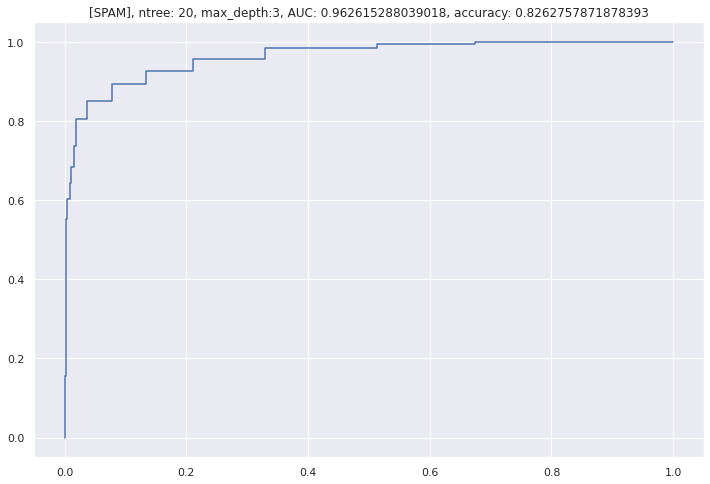

In [23]:
ntree = 20
max_depth = 3
rf = RandomForest()
rf.fit(X_train, y_train, ntree=ntree, max_depth=max_depth)
probs, classes = rf.predict(X_test)

auc, points_x, points_y = ROC_AUC(y_test, probs[:, 1]) # probabilities of the 2nd class
accuracy = accuracy_score(y_test, classes)

plt.figure(figsize=(12, 8))
plt.plot(points_x, points_y)
plt.title(f"[SPAM], ntree: {ntree}, max_depth:{max_depth}, AUC: {auc}, accuracy: {accuracy}")

Cross validation

In [25]:
ntree_p = [5, 10, 20, 30, 50, 100]
max_depth_p = [2, 3, 5, 7, 10]

best_auc = None
best_ntree = None
best_max_depth = None

kf = KFold(n_splits=5, random_state=42, shuffle=True)
for ntree in ntree_p:
    for max_depth in max_depth_p:
        roc_auc_CV = []
        for train_index, val_index in kf.split(X_train):
            X_train_new, X_val = X_train[train_index], X_train[val_index]
            y_train_new, y_val = y_train[train_index], y_train[val_index]
            rf = RandomForest()
            rf.fit(X_train_new, y_train_new, ntree=ntree, max_depth=max_depth)
            probs, classes = rf.predict(X_val)
            auc, points_x, points_y = ROC_AUC(y_val, probs[:, 1])
            roc_auc_CV.append(auc)
        auc = np.mean(roc_auc_CV)
        print(f"ntree: {ntree}, max_depth: {max_depth}, auc: {auc}")
        if not best_auc or best_auc < auc:
            best_auc = auc
            best_ntree = ntree
            best_max_depth = max_depth
print('--')            
print(f"best ntree: {best_ntree}, best max_depth: {best_max_depth}, AUC: {best_auc}")

ntree: 5, max_depth: 2, auc: 0.9519153306940284
ntree: 5, max_depth: 3, auc: 0.9514561671157434
ntree: 5, max_depth: 5, auc: 0.9672998085961778
ntree: 5, max_depth: 7, auc: 0.9641645225748225
ntree: 5, max_depth: 10, auc: 0.9556222951911748
ntree: 10, max_depth: 2, auc: 0.9544905229432009
ntree: 10, max_depth: 3, auc: 0.9563713564138213
ntree: 10, max_depth: 5, auc: 0.958540428472159
ntree: 10, max_depth: 7, auc: 0.9593752382566512
ntree: 10, max_depth: 10, auc: 0.9618414735638312
ntree: 20, max_depth: 2, auc: 0.954805585249372
ntree: 20, max_depth: 3, auc: 0.9594582405654913
ntree: 20, max_depth: 5, auc: 0.9577034407172675
ntree: 20, max_depth: 7, auc: 0.9579177174969191
ntree: 20, max_depth: 10, auc: 0.9660447901545043
ntree: 30, max_depth: 2, auc: 0.9574784018361994
ntree: 30, max_depth: 3, auc: 0.9568651389040055
ntree: 30, max_depth: 5, auc: 0.9575541445502822
ntree: 30, max_depth: 7, auc: 0.9634157992834715
ntree: 30, max_depth: 10, auc: 0.9654842415516306
ntree: 50, max_depth: 2

ROC-curve on the test set (optimal parameters)

Text(0.5, 1.0, '[SPAM], ntree: 5, max_depth: 5, AUC: 0.9401178231686772, accuracy: 0.8045602605863192')

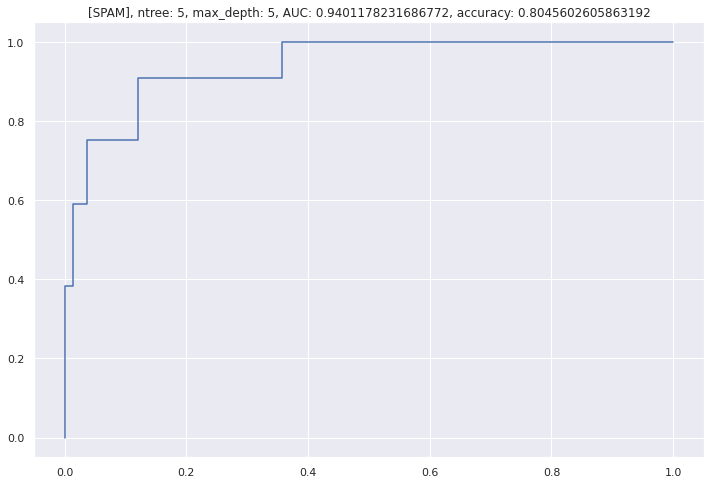

In [27]:
ntree = best_ntree
max_depth = best_max_depth
rf = RandomForest()
rf.fit(X_train, y_train, ntree=ntree, max_depth=max_depth)
probs, classes = rf.predict(X_test)

auc, points_x, points_y = ROC_AUC(y_test, probs[:, 1]) # probabilities of the 2nd class
accuracy = accuracy_score(y_test, classes)

plt.figure(figsize=(12, 8))
plt.plot(points_x, points_y)
plt.title(f"[SPAM], ntree: {ntree}, max_depth: {max_depth}, AUC: {auc}, accuracy: {accuracy}")

### Cancer dataset

In [28]:
cancer_df = pd.read_csv('cancer.csv')
cancer_df['int_label'] = cancer_df.label.map({'M':1, 'B':0})
cancer_df['label'] = cancer_df.int_label
cancer_df.drop('int_label', axis=1, inplace=True)
X = cancer_df[cancer_df.columns.difference(['label'])].values
y = cancer_df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

20 trees, max_depth = 3

Text(0.5, 1.0, '[Cancer], ntree: 20, max_depth:3, AUC: 0.9967245332459868, accuracy: 0.9473684210526315')

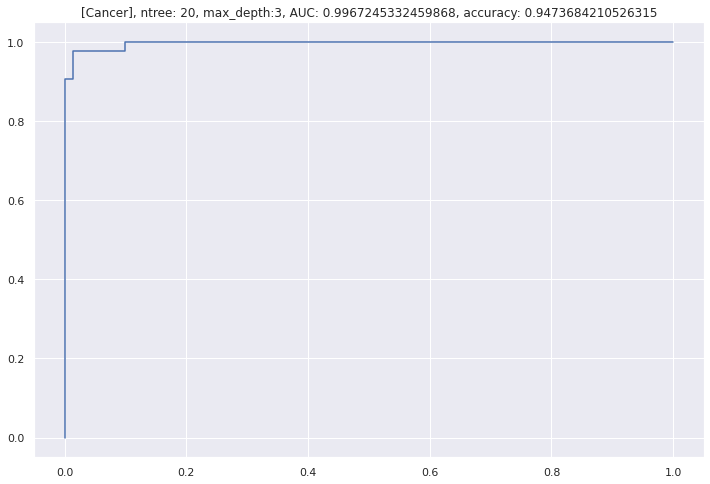

In [29]:
ntree = 20
max_depth = 3
rf = RandomForest()
rf.fit(X_train, y_train, ntree=ntree, max_depth=max_depth)
probs, classes = rf.predict(X_test)

auc, points_x, points_y = ROC_AUC(y_test, probs[:, 1]) # probabilities of the 2nd class
accuracy = accuracy_score(y_test, classes)

plt.figure(figsize=(12, 8))
plt.plot(points_x, points_y)
plt.title(f"[Cancer], ntree: {ntree}, max_depth:{max_depth}, AUC: {auc}, accuracy: {accuracy}")

Cross validation

In [31]:
ntree_p = [5, 10, 20, 30, 50, 100]
max_depth_p = [2, 3, 5, 7, 10]

best_auc = None
best_ntree = None
best_max_depth = None

kf = KFold(n_splits=5, random_state=42, shuffle=True)
for ntree in ntree_p:
    for max_depth in max_depth_p:
        roc_auc_CV = []
        for train_index, val_index in kf.split(X_train):
            X_train_new, X_val = X_train[train_index], X_train[val_index]
            y_train_new, y_val = y_train[train_index], y_train[val_index]
            rf = RandomForest()
            rf.fit(X_train_new, y_train_new, ntree=ntree, max_depth=max_depth)
            probs, classes = rf.predict(X_val)
            auc, points_x, points_y = ROC_AUC(y_val, probs[:, 1])
            roc_auc_CV.append(auc)
        auc = np.mean(roc_auc_CV)
        print(f"ntree: {ntree}, max_depth: {max_depth}, auc: {auc}")
        if not best_auc or best_auc < auc:
            best_auc = auc
            best_ntree = ntree
            best_max_depth = max_depth
print('--')            
print(f"best ntree: {best_ntree}, best max_depth: {best_max_depth}, AUC: {best_auc}")

ntree: 5, max_depth: 2, auc: 0.9879630226057665
ntree: 5, max_depth: 3, auc: 0.9873810447733126
ntree: 5, max_depth: 5, auc: 0.987728825452822
ntree: 5, max_depth: 7, auc: 0.9861590260333953
ntree: 5, max_depth: 10, auc: 0.9870802168714595
ntree: 10, max_depth: 2, auc: 0.9848673491940779
ntree: 10, max_depth: 3, auc: 0.9888155682291563
ntree: 10, max_depth: 5, auc: 0.9877790551940265
ntree: 10, max_depth: 7, auc: 0.9885234863105076
ntree: 10, max_depth: 10, auc: 0.9892265850837786
ntree: 20, max_depth: 2, auc: 0.9825587228826793
ntree: 20, max_depth: 3, auc: 0.9840442300514869
ntree: 20, max_depth: 5, auc: 0.9892623192537455
ntree: 20, max_depth: 7, auc: 0.9902956059589126
ntree: 20, max_depth: 10, auc: 0.9872028188745942
ntree: 30, max_depth: 2, auc: 0.9817220646216939
ntree: 30, max_depth: 3, auc: 0.9867356196371435
ntree: 30, max_depth: 5, auc: 0.9853257467620319
ntree: 30, max_depth: 7, auc: 0.990672645887261
ntree: 30, max_depth: 10, auc: 0.9860565768361628
ntree: 50, max_depth: 2

ROC-curve on the test set (optimal parameters)

Text(0.5, 1.0, '[Cancer], ntree: 100, max_depth: 7, AUC: 0.997052079921388, accuracy: 0.9649122807017544')

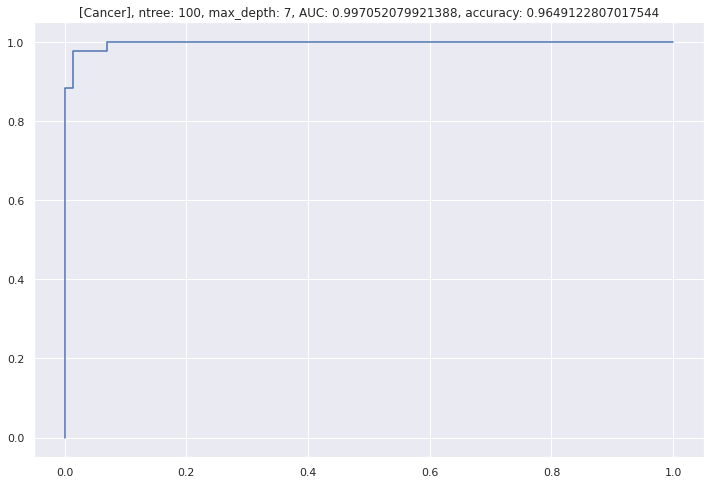

In [32]:
ntree = best_ntree
max_depth = best_max_depth
rf = RandomForest()
rf.fit(X_train, y_train, ntree=ntree, max_depth=max_depth)
probs, classes = rf.predict(X_test)

auc, points_x, points_y = ROC_AUC(y_test, probs[:, 1]) # probabilities of the 2nd class
accuracy = accuracy_score(y_test, classes)

plt.figure(figsize=(12, 8))
plt.plot(points_x, points_y)
plt.title(f"[Cancer], ntree: {ntree}, max_depth: {max_depth}, AUC: {auc}, accuracy: {accuracy}")

# Задание 4